# **Pesawit**

In [65]:
import zipfile, os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense,Dropout,Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

In [66]:
dataset_zip = zipfile.ZipFile('Date Palm data.zip', 'r') # Changed Zipfile to ZipFile

dataset_zip.extractall()

dataset_zip.close()

# Inisialisasi list untuk menyimpan file paths dan labels

In [67]:
filepaths = []
labels = []

# Daftar kelas penyakit atau kondisi yang ada di dataset

In [68]:
sdir = 'Date Palm data'

classlist = os.listdir(sdir)

# Menyusun file paths dan label sesuai struktur dataset

In [69]:
for klass in classlist:
    classpath = os.path.join(sdir, klass)
    if os.path.isdir(classpath):
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            filepaths.append(fpath)
            labels.append(klass)

In [70]:
# Membuat DataFrame dengan file paths dan labels
df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

In [71]:
# Tampilkan 5 data pertama dan hitung jumlah masing-masing label
print(df.head())
print(df['labels'].value_counts())

                                       filepaths       labels
0  Date Palm data/brown spots/brownspots-344.jpg  brown spots
1  Date Palm data/brown spots/brownspots-127.jpg  brown spots
2  Date Palm data/brown spots/brownspots-363.jpg  brown spots
3  Date Palm data/brown spots/brownspots-422.jpg  brown spots
4  Date Palm data/brown spots/brownspots-156.jpg  brown spots
labels
healthy        1203
white scale     958
brown spots     470
Name: count, dtype: int64


In [72]:
# Visualisasi beberapa gambar dalam dataset
def visualize_images(df, n_images=5):
    fig, axes = plt.subplots(1, n_images, figsize=(15, 5))
    for i in range(n_images):
        img_path = df['filepaths'].iloc[i]
        img = load_img(img_path, target_size=(224, 224))
        axes[i].imshow(img)
        axes[i].set_title(df['labels'].iloc[i])
        axes[i].axis('off')
    plt.show()

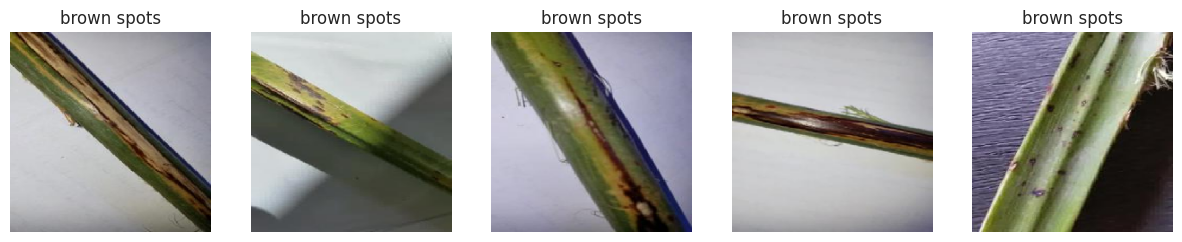

In [73]:
# Visualisasikan 5 gambar pertama
visualize_images(df, n_images=5)

In [74]:
# Mengubah gambar menjadi array numerik
def load_and_preprocess_images(df, img_size=(224, 224)):
    images = []
    for img_path in df['filepaths']:
        img = load_img(img_path, target_size=img_size)
        img = img_to_array(img)
        img = img / 255.0
        images.append(img)
    return np.array(images)

In [75]:
# Menyusun data gambar
images = load_and_preprocess_images(df)

In [76]:

le = LabelEncoder()
labels = le.fit_transform(df['labels'])

In [77]:
# Membagi data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [78]:
# Tampilkan dimensi data setelah pemisahan
print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")

Training data shape: (2104, 224, 224, 3), Test data shape: (527, 224, 224, 3)


In [79]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='reflect'
)

In [80]:
# Untuk data validasi (test), hanya rescaling yang dilakukan
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [81]:
# Memperoleh data pelatihan dan pengujian dengan augmentasi
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
validation_generator = test_datagen.flow(X_test, y_test, batch_size=32)

In [82]:
# Visualisasi beberapa gambar hasil augmentasi
def visualize_augmentation(generator, n_images=5):
    fig, axes = plt.subplots(1, n_images, figsize=(15, 5))
    for i in range(n_images):
        img_batch, _ = next(generator)
        img = img_batch[0]
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.show()

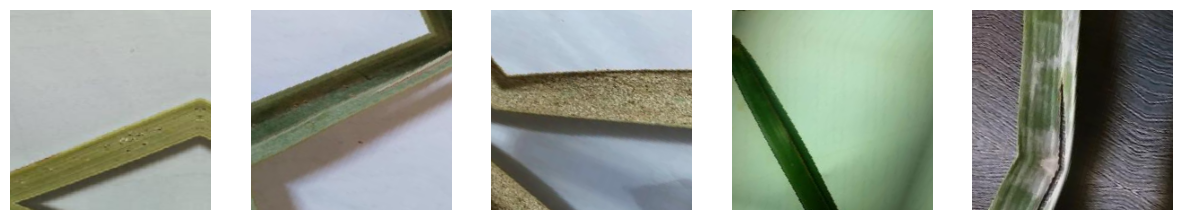

In [83]:
# Visualisasikan 5 gambar pertama hasil augmentasi
visualize_augmentation(train_generator, n_images=5)

### **Model**

1. Memuat Dataset dan Preprocessing Data

In [84]:
# Print the distribution of labels
print(df['labels'].value_counts())

labels
healthy        1203
white scale     958
brown spots     470
Name: count, dtype: int64


2. Augmentasi Data untuk Menyamakan Jumlah Sampel di Tiap Kelas

In [85]:
# Augmentasi data untuk setiap label hingga jumlah sama
max_samples = df['labels'].value_counts().max()
augmented_data = []

for label in df['labels'].unique():
    subset = df[df['labels'] == label]
    diff = max_samples - len(subset)
    if diff > 0:
        augmented_subset = subset.sample(n=diff, replace=True, random_state=42)
        augmented_data.append(augmented_subset)

# Gabungkan data augmentasi
df_augmented = pd.concat([df] + augmented_data)

3. Membagi Data Menjadi Train, Validation, dan Test Set

In [86]:
# Membagi dataset menjadi train (70%), validation (20%), test (10%)
train_data, temp_data = train_test_split(df_augmented, test_size=0.30, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=(1/3), random_state=42)

print(f"Train: {len(train_data)}, Validation: {len(val_data)}, Test: {len(test_data)}")

Train: 2526, Validation: 722, Test: 361


4. Membuat Generator Augmentasi Gambar

In [87]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, horizontal_flip=True, zoom_range=0.2)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_data, x_col='filepaths', y_col='labels', target_size=(224, 224), class_mode='categorical', batch_size=32)

val_generator = val_datagen.flow_from_dataframe(
    val_data, x_col='filepaths', y_col='labels', target_size=(224, 224), class_mode='categorical', batch_size=32)

test_generator = test_datagen.flow_from_dataframe(
    test_data, x_col='filepaths', y_col='labels', target_size=(224, 224), class_mode='categorical', batch_size=32)

Found 2526 validated image filenames belonging to 3 classes.
Found 722 validated image filenames belonging to 3 classes.
Found 361 validated image filenames belonging to 3 classes.


5. Membuat Model CNN

In [88]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, validation_data=val_generator, epochs=50)

Epoch 1/50
79/79 [==============================] - 30s 344ms/step - loss: 1.0702 - accuracy: 0.5123 - val_loss: 0.6150 - val_accuracy: 0.7175
Epoch 2/50
79/79 [==============================] - 28s 354ms/step - loss: 0.5835 - accuracy: 0.7363 - val_loss: 0.4394 - val_accuracy: 0.7922
Epoch 3/50
79/79 [==============================] - 25s 318ms/step - loss: 0.3952 - accuracy: 0.8298 - val_loss: 0.2414 - val_accuracy: 0.9017
Epoch 4/50
79/79 [==============================] - 28s 353ms/step - loss: 0.3221 - accuracy: 0.8610 - val_loss: 0.3698 - val_accuracy: 0.8366
Epoch 5/50
79/79 [==============================] - 25s 321ms/step - loss: 0.3000 - accuracy: 0.8757 - val_loss: 0.1684 - val_accuracy: 0.9224
Epoch 6/50
79/79 [==============================] - 27s 347ms/step - loss: 0.2611 - accuracy: 0.8959 - val_loss: 0.1407 - val_accuracy: 0.9474
Epoch 7/50
79/79 [==============================] - 27s 346ms/step - loss: 0.2224 - accuracy: 0.9133 - val_loss: 0.1256 - val_accuracy: 0.9515

In [89]:
train_loss, train_accuracy = model.evaluate(train_generator) # Get both loss and accuracy
print(f"Training Accuracy: {train_accuracy:.2f}, Training Loss: {train_loss:.2f}")

# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(val_generator) # Get both loss and accuracy
print(f"Validation Accuracy: {val_accuracy:.2f}, Validation Loss: {val_loss:.2f}")

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator) # Get both loss and accuracy
print(f"Test Accuracy: {test_accuracy:.2f}, Test Loss: {test_loss:.2f}")

79/79 [==============================] - 27s 338ms/step - loss: 0.0072 - accuracy: 0.9976
Training Accuracy: 1.00, Training Loss: 0.01
23/23 [==============================] - 1s 43ms/step - loss: 0.0172 - accuracy: 0.9945
Validation Accuracy: 0.99, Validation Loss: 0.02
12/12 [==============================] - 2s 163ms/step - loss: 0.0166 - accuracy: 0.9945
Test Accuracy: 0.99, Test Loss: 0.02


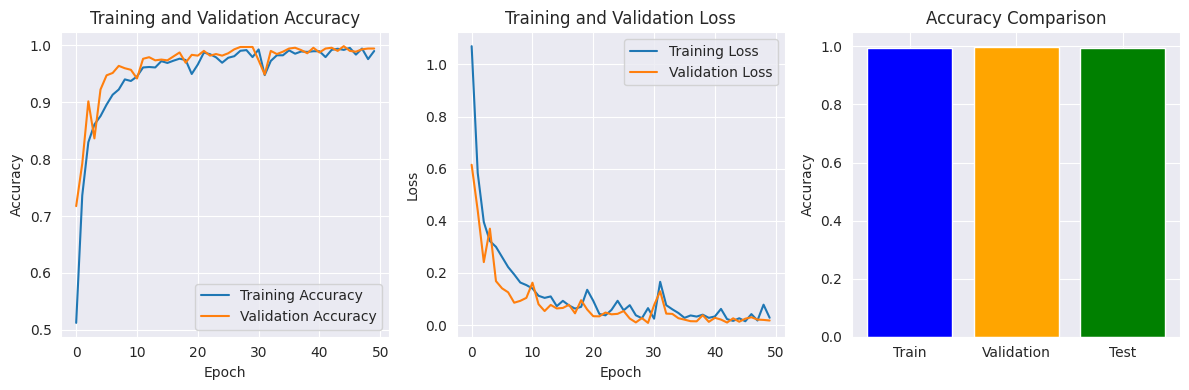

In [90]:


plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 3, 3)
plt.bar(['Train', 'Validation', 'Test'], [max(history.history['accuracy']), max(history.history['val_accuracy']), test_accuracy], color=['blue', 'orange', 'green']) # Replace with your actual accuracy
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [91]:
model.save('model.keras')